In [48]:
import pydicom as dicom
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from mpl_toolkits.mplot3d import Axes3D

### Abrir la imagen asignada

In [3]:
def open_image(path_to_image):
    ds = dicom.dcmread(path_to_image)
    return ds.pixel_array

def im_uint8(image):
    return (image / np.max(image) * 255).astype(np.uint8)


PATH = os.path.join('C://Users\mario\DataspellProjects\spatial_filters_biomed\DICOM_image', 'im1.dcm')
pixel_data = open_image(PATH)
pixel_data_uint8 = im_uint8(pixel_data)

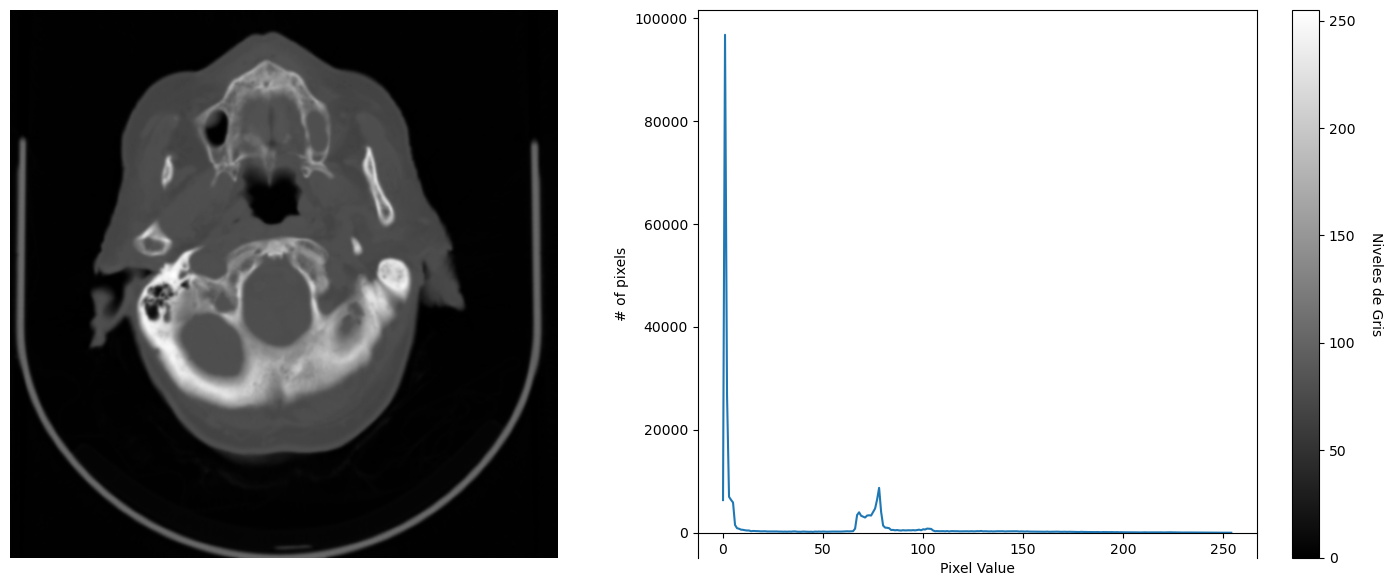

In [4]:
def histogram_image(image):
    fig, axes = plt.subplots(1, 2, figsize=(15,6))
    #Plot the image
    im = axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')
    bins = np.max(image)
    # Plot the histogram
    hist = cv2.calcHist([image], [0], None, [bins], [0, bins])
    axes[1].plot(hist)
    axes[1].set_xlabel("Pixel Value")
    axes[1].set_ylabel("# of pixels")
    # Move the x-axis to y=0
    axes[1].spines['bottom'].set_position('zero')
    cbar = plt.colorbar(im, ax=axes[1])
    cbar.set_label('Niveles de Gris', rotation=270, labelpad=20)
    plt.tight_layout()
    plt.show()
    return None

histogram_image(pixel_data_uint8)

### Visualización de filtros

In [4]:
def visualize_filter(filter_matrix):
    # Crear un grid para las coordenadas x, y
    x, y = np.mgrid[0:filter_matrix.shape[0], 0:filter_matrix.shape[1]]
    
    # Crear un subplot con 1 fila y 3 columnas
    fig = plt.figure(figsize = (15,5))
    
    # 1. Visualización 2D del perfil del filtro
    ax = fig.add_subplot(131)
    # Tomar el corte central a través del filtro (a través del centro)
    central_slice = filter_matrix[filter_matrix.shape[0] // 2, :]
    ax.plot(central_slice)
    ax.set_title('Visualización del perfil 2D')

    # 2. Visualización 3D del filtro
    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(x, y, filter_matrix, cmap='viridis', rstride=1, cstride=1, linewidth=0, antialiased=False)
    ax.set_title('Visualización 3D')
    
    # 3. Heatmap con anotaciones
    ax = fig.add_subplot(133)
    cax = ax.imshow(filter_matrix, cmap='viridis', interpolation='nearest')
    ax.set_title('Heatmap')
    cbar = plt.colorbar(cax, ax=ax)
    
    plt.show()


Error con los ejes solucionado en: ![https://stackoverflow.com/questions/67917434/bothering-frame-on-matplotlib-3d-plots]

### Aplicación de los filtros

In [12]:
def convolution(image, kernel):
    height, width = image.shape
    k_height, k_width = kernel.shape
    # Zero-Padding
    pad_height, pad_width = k_height // 2, k_width // 2
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), 'constant')
    # Incializamos la imagen de salida
    output = np.zeros_like(image)
    # Operación de convolución
    for i in range(height):
        for j in range(width):
            region = padded_image[i:i+k_height, j:j+k_width]
            output[i, j] = np.sum(region * kernel)
    return output

In [5]:
def im2col(image, k_height, k_width):
    """
    Transform the image into a column matrix where each column is a 
    stretched version of a local receptive field (a small block in the image).

    Parameters:
    image (np.ndarray): The padded image.
    k_height, k_width (int): The dimensions of the kernel.

    Returns:
    np.ndarray: The column matrix.
    """
    # Get dimensions
    height, width = image.shape
    out_height = height - k_height + 1
    out_width = width - k_width + 1

    # Initialize the column matrix
    cols = np.zeros((k_height * k_width, out_height * out_width))

    # Fill in the column matrix
    for i in range(k_height):
        for j in range(k_width):
            patch = image[i:i+out_height, j:j+out_width]
            cols[i*k_width + j, :] = patch.flatten()

    return cols

def efficient_convolution(image, kernel):
    """
    Perform convolution without nested loops.
    
    Parameters:
    image (np.ndarray): 2D array representing the grayscale image.
    kernel (np.ndarray): 2D array representing the convolution kernel.
    
    Returns:
    np.ndarray: 2D array representing the output image after convolution.
    """
    # Get dimensions
    height, width = image.shape
    k_height, k_width = kernel.shape

    # Padding the image
    pad_height, pad_width = int(k_height // 2), int(k_width // 2)
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), 'constant')

    # Convert image to column matrix
    image_cols = im2col(padded_image, k_height, k_width)

    # Flatten the kernel and perform matrix multiplication
    kernel_flat = kernel.flatten()
    output_cols = kernel_flat @ image_cols

    # Reshape the output to the image shape 
    output = output_cols.reshape(height, width)

    return output

### 1. Filtrado espacial de la imagen

#### 1.1. Filtro paso bajo donde los coeficientes valen 1

In [149]:
def low_pass_filter(kernel_size):
    # Para ello debemos crear una matriz de unos cuadrada tan grande como se
    # indique en kernel_size. Luego, dividimos por la cantidad de elementos
    # de la matriz (kernel_size ** 2)
    return np.divide(np.ones((kernel_size, kernel_size)), (kernel_size ** 2))

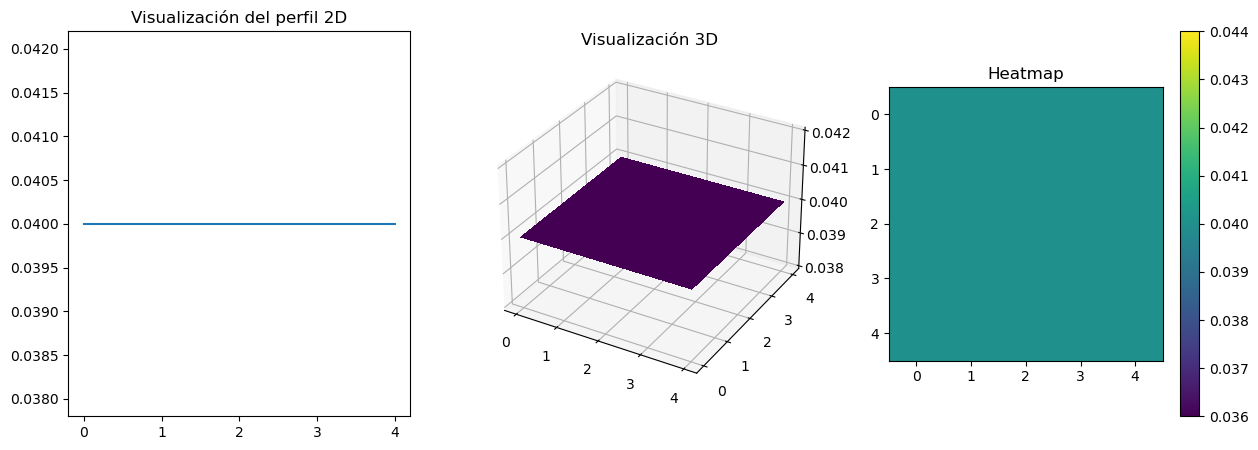

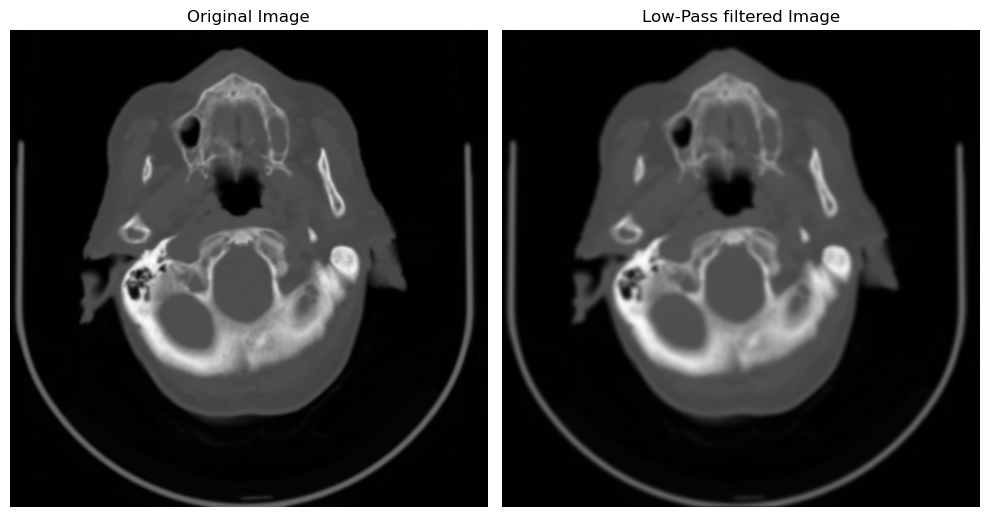

In [150]:
lowpass = low_pass_filter(5)    
visualize_filter(lowpass)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(121)
ax.imshow(pixel_data_uint8, cmap='gray')
ax.axis('off')
ax.set_title('Original Image')

ax = fig.add_subplot(122)
ax.imshow(efficient_convolution(pixel_data_uint8, lowpass), cmap='gray')
ax.axis('off')
ax.set_title('Low-Pass filtered Image')


plt.tight_layout()
plt.show()

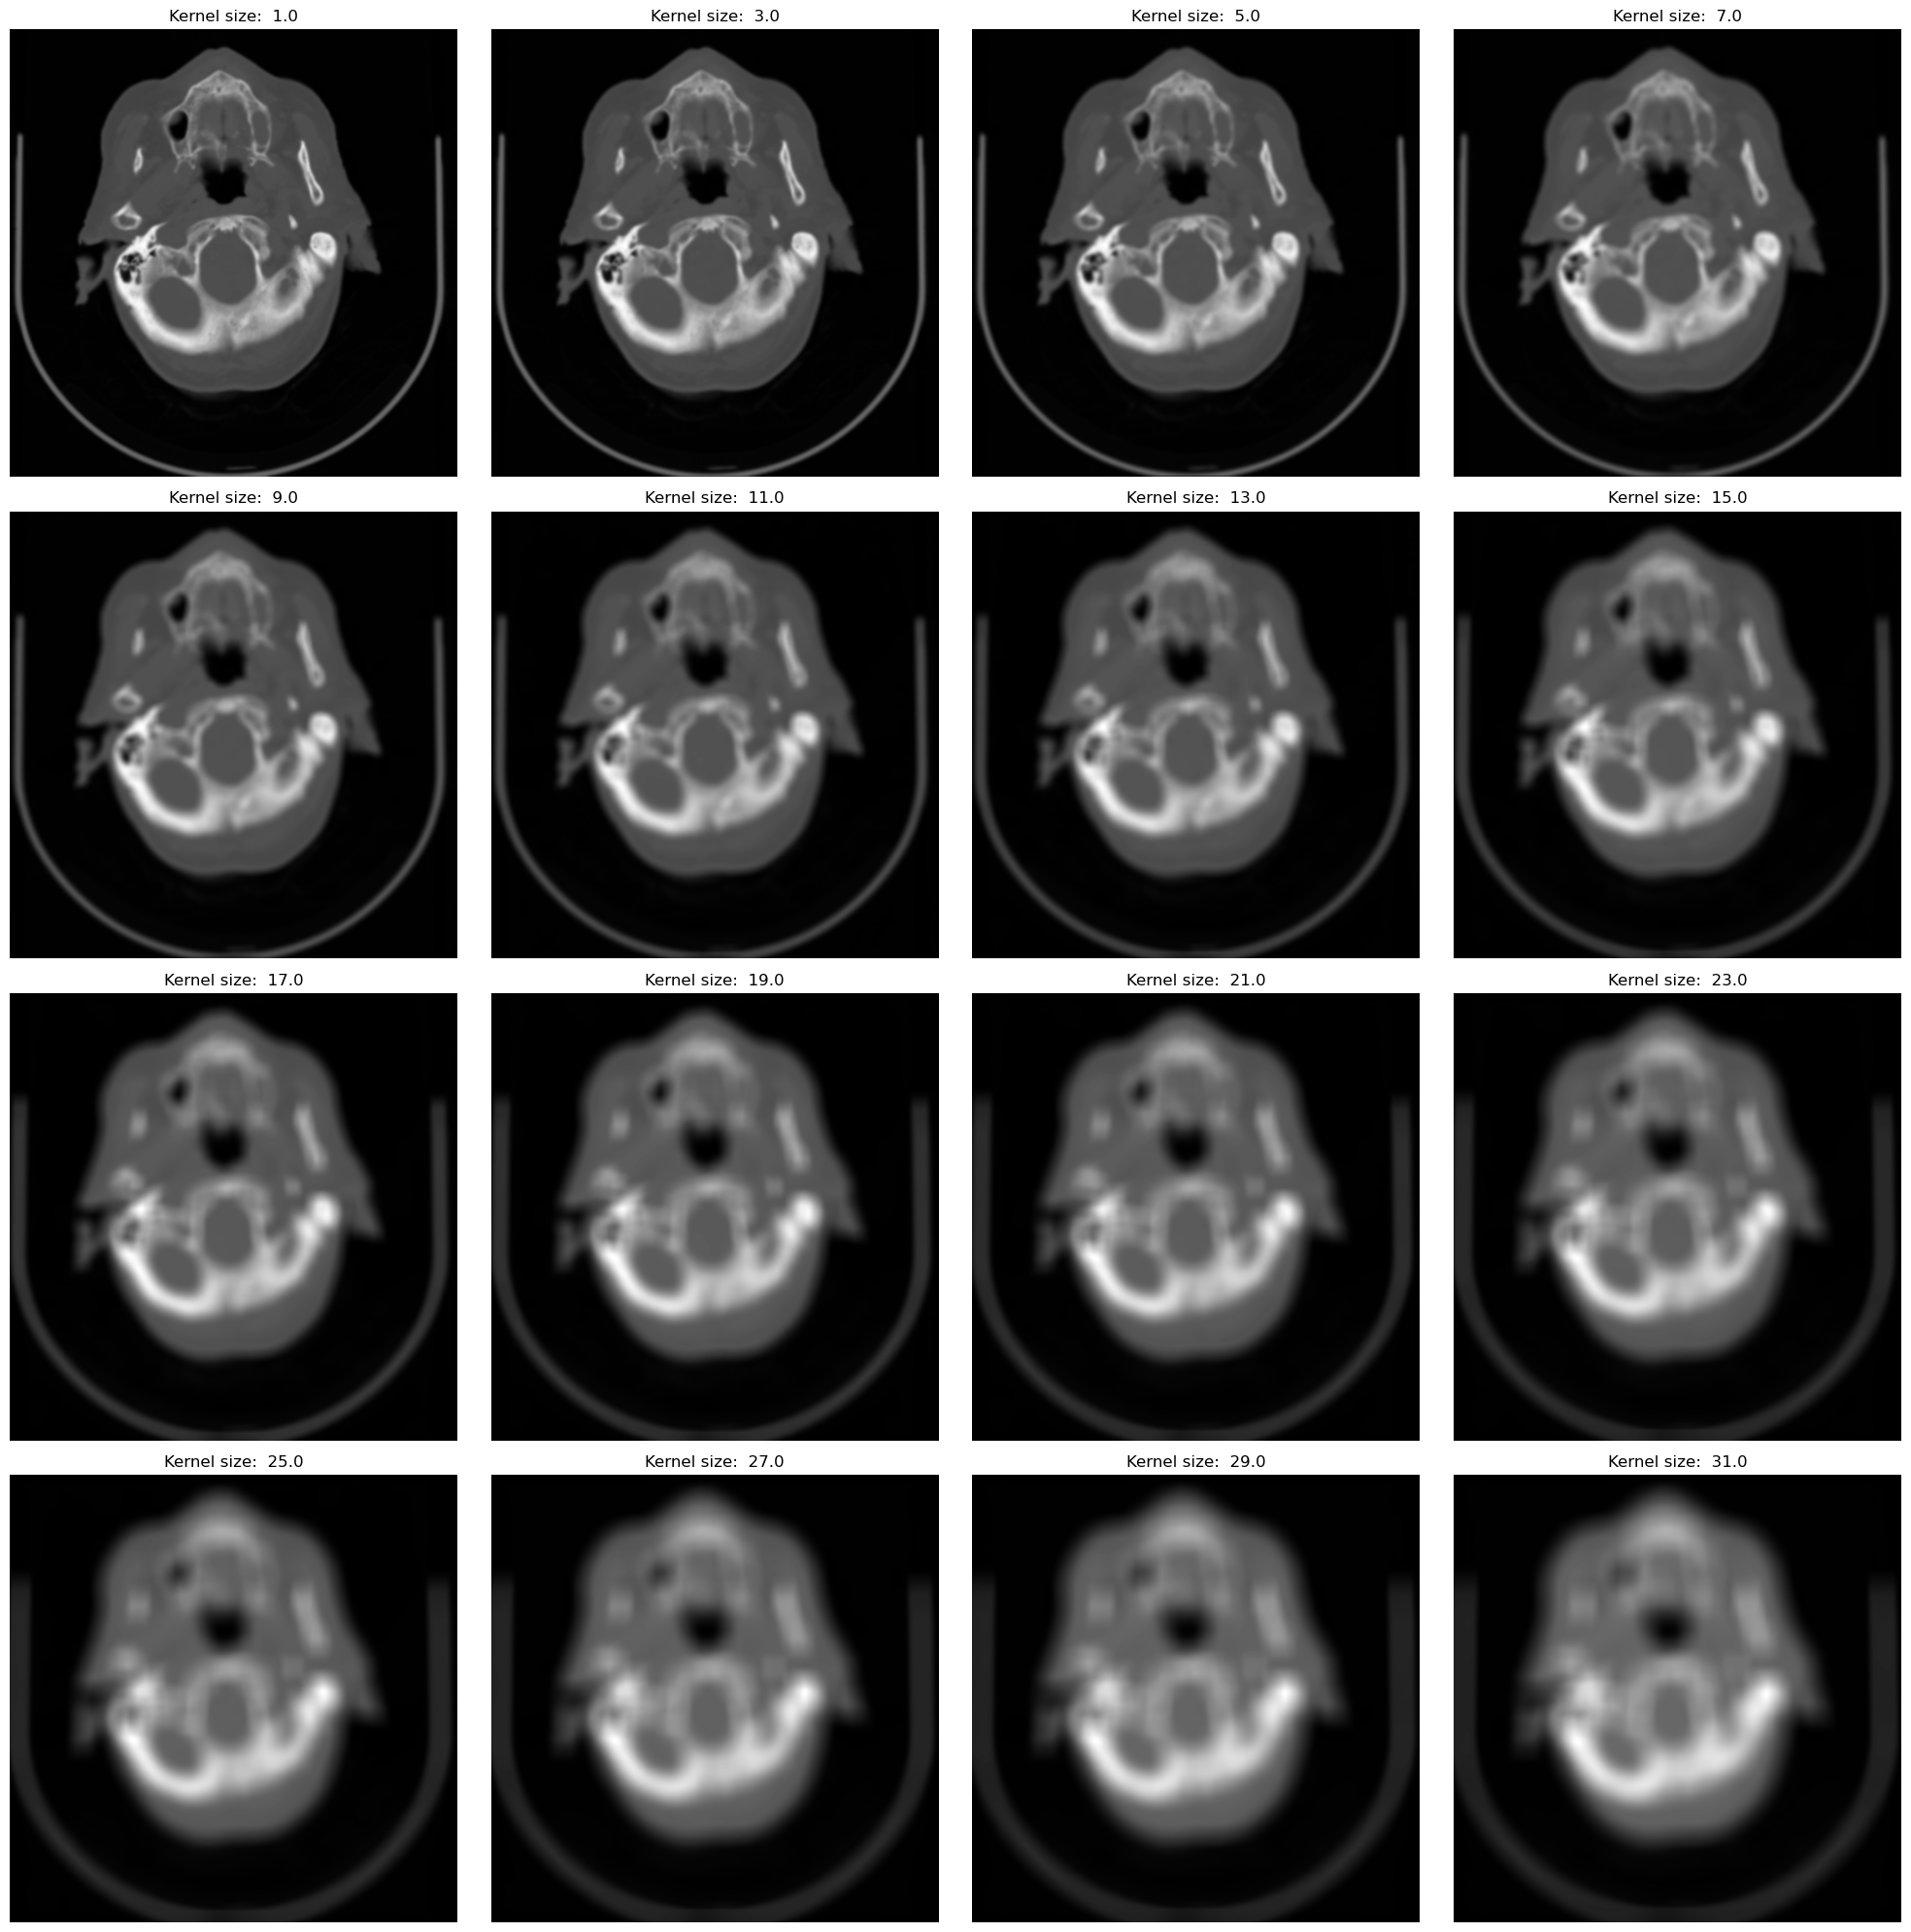

In [50]:
def plt_lowpass_images(image, kernel_sizes):
    plt.figure(figsize=(20, 20))
    for i, size in enumerate(kernel_sizes):
        lowpass_f = low_pass_filter(size)
        plt.subplot(4, 4, i+1)
        plt.imshow(efficient_convolution(image, lowpass_f), cmap='gray')
        plt.title(f"Kernel size: {size: .1f}")
        plt.axis('off')
    plt.tight_layout()

sizes = np.arange(1, 33, 2)
plt_lowpass_images(pixel_data_uint8, sizes)

#### Filtros Prewitt

In [64]:
def prewitt_custom(kernel_size):
    # Primero se genera la base, que será un array de datos en el rango:
    # [-kernel_size, 0, kernel_size]
    base = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    # np.outer(P, Q) es interesante:
    # Crea una matriz de tamaño PxQ tal que: 
    # [ [p0*q0, p0*q1, p0*q2, ... p0*qN ], 
    # [             (...)               ]
    # [ [pN*q0, pN*q1, pN*q2, ..., pN*qN]]
    # Por lo que senta las bases para el filtro Sobel eficientemente
    prewitt_x = np.outer(base, np.ones(kernel_size))
    return prewitt_x, prewitt_x.T

from scipy.ndimage import prewitt


def apply_prewitt_scipy(image, axis=None):
    image_float = image.astype(np.float32)
    # Applying Prewitt filter in x and y directions
    if axis in [0, 1]:
        prewitt_output = prewitt(image_float, axis=axis)
    else:
        prewitt_x = prewitt(image_float, axis=0)
        prewitt_y = prewitt(image_float, axis=1)
        prewitt_output = np.hypot(prewitt_x, prewitt_y)

    prewitt_output = (prewitt_output - prewitt_output.min()) / (prewitt_output.max() - prewitt_output.min())
    return prewitt_output

Ojo!!! que el np.outer es muy interesante:

```
x = np.array(['a', 'b', 'c'], dtype=object)

np.outer(x, [1, 2, 3])
array([['a', 'aa', 'aaa'],
       ['b', 'bb', 'bbb'],
       ['c', 'cc', 'ccc']], dtype=object)
```


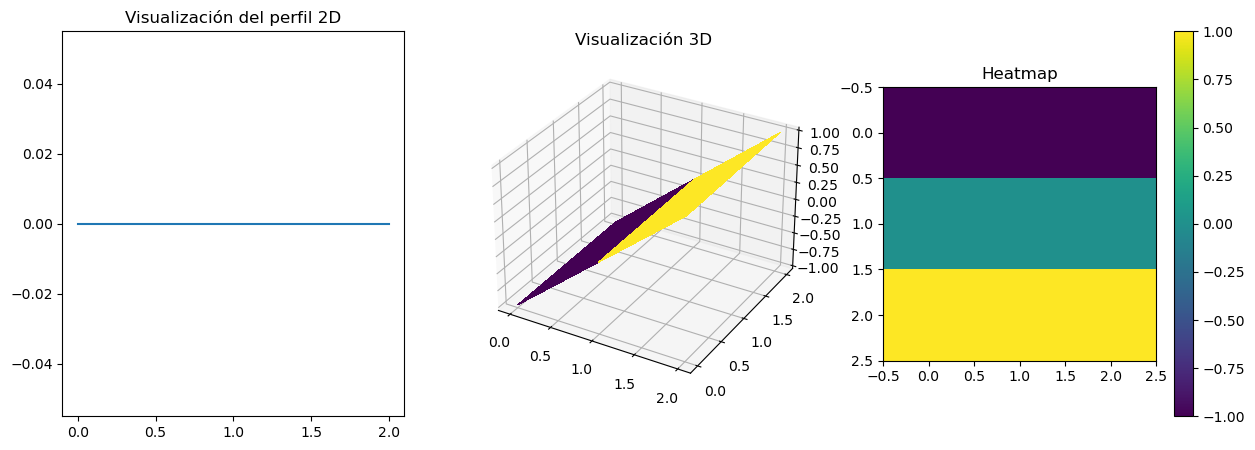

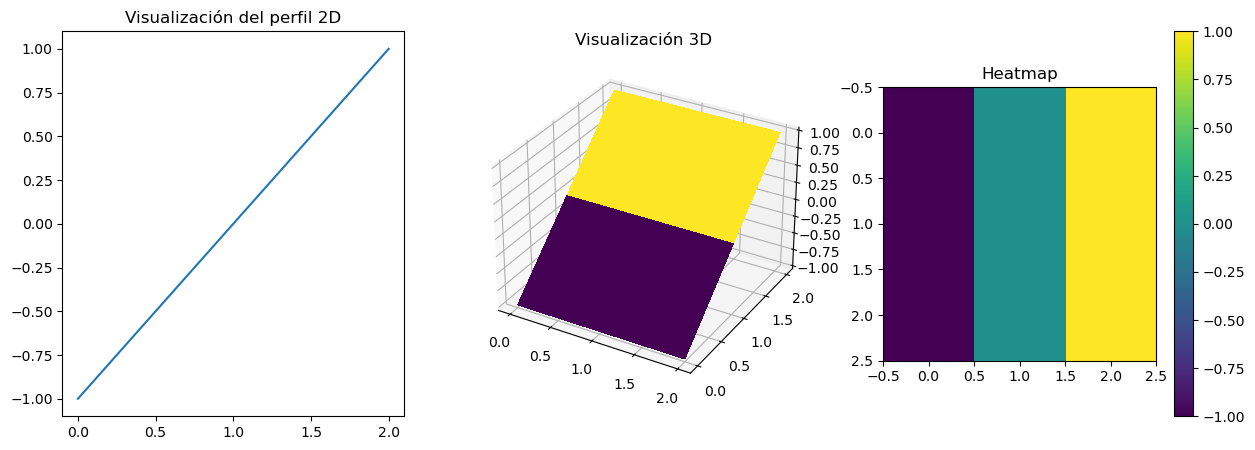

In [68]:
prewitt_cusmtom_x, prewitt_cusmtom_y = prewitt_custom(3)

visualize_filter(prewitt_cusmtom_x)
visualize_filter(prewitt_cusmtom_y)

In [65]:
def visualize_prewitt_3x3(image):
    # Sobel que he implementado
    prewitt_x_custom, prewitt_y_custom = prewitt_custom(3)
    prewitt_x_custom = efficient_convolution(pixel_data_uint8, prewitt_x_custom)
    prewitt_y_custom = efficient_convolution(pixel_data_uint8, prewitt_y_custom)
    prewitt_combined_custom = normalize_image(np.hypot(prewitt_x_custom, prewitt_y_custom))

    # Sobel usando scipy.ndimage
    prewitt_x_scipy = apply_prewitt_scipy(image, axis=0)
    prewitt_y_scipy = apply_prewitt_scipy(image, axis=1)
    prewitt_combined_scipy = normalize_image(apply_prewitt_scipy(image))

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    # Imagen original en el centro
    axs[0, 1].imshow(image, cmap='gray')
    axs[0, 1].set_title('Original Image')
    axs[0, 1].axis('off')

    # Visualización de tu implementación de Sobel
    axs[1, 0].imshow(prewitt_x_custom, cmap='gray')
    axs[1, 0].set_title('Prewitt X (Custom)')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(prewitt_y_custom, cmap='gray')
    axs[1, 1].set_title('Prewitt Y (Custom)')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(prewitt_combined_custom, cmap='gray')
    axs[1, 2].set_title('Prewitt Combined (Custom)')
    axs[1, 2].axis('off')

    # Visualización de Sobel usando scipy.ndimage
    axs[2, 0].imshow(prewitt_x_scipy, cmap='gray')
    axs[2, 0].set_title('Prewitt X (Scipy)')
    axs[2, 0].axis('off')

    axs[2, 1].imshow(prewitt_y_scipy, cmap='gray')
    axs[2, 1].set_title('Prewitt Y (Scipy)')
    axs[2, 1].axis('off')

    axs[2, 2].imshow(prewitt_combined_scipy, cmap='gray')
    axs[2, 2].set_title('Prewitt Combined (Scipy)')
    axs[2, 2].axis('off')

    # Las posiciones vacías
    axs[0, 0].axis('off')
    axs[0, 2].axis('off')

    plt.tight_layout()
    plt.show()

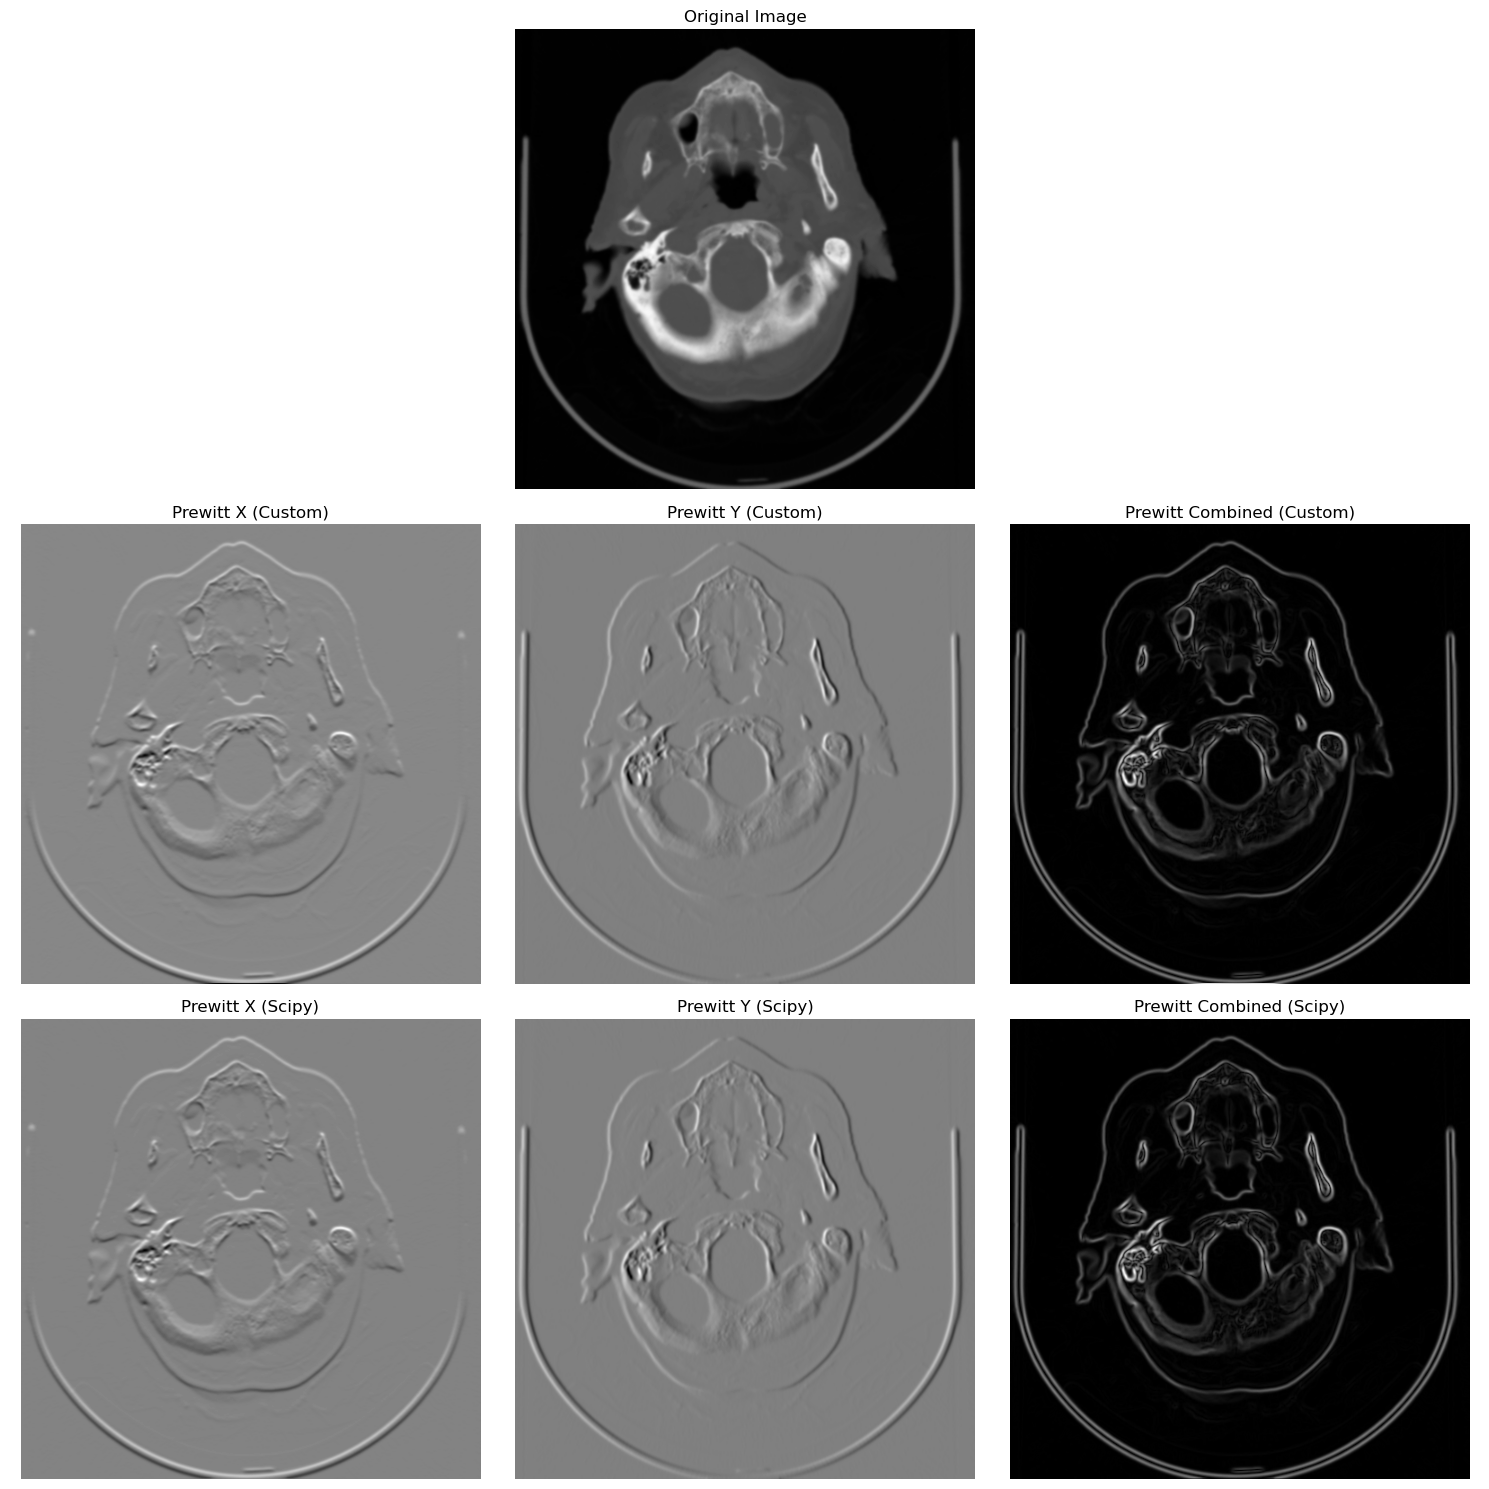

In [66]:
visualize_prewitt_3x3(pixel_data_uint8)

#### Filtros Sobel

In [25]:
def normalize_image(image):

    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = ((image - min_val) / (max_val - min_val)) * 255
    return normalized_image.astype(np.uint8)

In [72]:
from scipy.ndimage import sobel

def apply_sobel_scipy(image, axis=None):
    # Convert the image to float for better handling of negative values
    image_float = image.astype(np.float32)

    # Applying Sobel filter along the specified axis
    if axis in [0, 1]:
        sobel_output = sobel(image_float, axis=axis)
    else:
        sobel_x = sobel(image_float, axis=0)
        sobel_y = sobel(image_float, axis=1)
        sobel_output = np.hypot(sobel_x, sobel_y)  # Combined magnitude

    # Normalize the output to [0, 1]
    sobel_output = (sobel_output - sobel_output.min()) / (sobel_output.max() - sobel_output.min())

    return sobel_output


def sobel_custom(kernel_size):
    sobel_x, sobel_y = prewitt_custom(kernel_size)
    sobel_x, sobel_y= np.copy(sobel_x), np.copy(sobel_y)
    sobel_x[:, kernel_size // 2] *= 2
    sobel_y[kernel_size // 2, :] *= 2
    return sobel_x, sobel_y

In [52]:
def visualize_sobel_3x3(image):
    # Sobel que he implementado
    sobel_x_custom, sobel_y_custom = sobel_custom(3)
    sobel_x_custom = efficient_convolution(pixel_data_uint8, sobel_x_custom)
    sobel_y_custom = efficient_convolution(pixel_data_uint8, sobel_y_custom)
    sobel_combined_custom = normalize_image(np.hypot(sobel_x_custom, sobel_y_custom))

    # Sobel usando scipy.ndimage
    sobel_x_scipy = apply_sobel_scipy(image, axis=0)
    sobel_y_scipy = apply_sobel_scipy(image, axis=1)
    sobel_combined_scipy = normalize_image(apply_sobel_scipy(image))

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    # Imagen original en el centro
    axs[0, 1].imshow(image, cmap='gray')
    axs[0, 1].set_title('Original Image')
    axs[0, 1].axis('off')

    # Visualización de tu implementación de Sobel
    axs[1, 0].imshow(sobel_x_custom, cmap='gray')
    axs[1, 0].set_title('Sobel X (Custom)')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(sobel_y_custom, cmap='gray')
    axs[1, 1].set_title('Sobel Y (Custom)')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(sobel_combined_custom, cmap='gray')
    axs[1, 2].set_title('Sobel Combined (Custom)')
    axs[1, 2].axis('off')

    # Visualización de Sobel usando scipy.ndimage
    axs[2, 0].imshow(sobel_x_scipy, cmap='gray')
    axs[2, 0].set_title('Sobel X (Scipy)')
    axs[2, 0].axis('off')

    axs[2, 1].imshow(sobel_y_scipy, cmap='gray')
    axs[2, 1].set_title('Sobel Y (Scipy)')
    axs[2, 1].axis('off')

    axs[2, 2].imshow(sobel_combined_scipy, cmap='gray')
    axs[2, 2].set_title('Sobel Combined (Scipy)')
    axs[2, 2].axis('off')

    # Las posiciones vacías
    axs[0, 0].axis('off')
    axs[0, 2].axis('off')

    plt.tight_layout()
    plt.show()

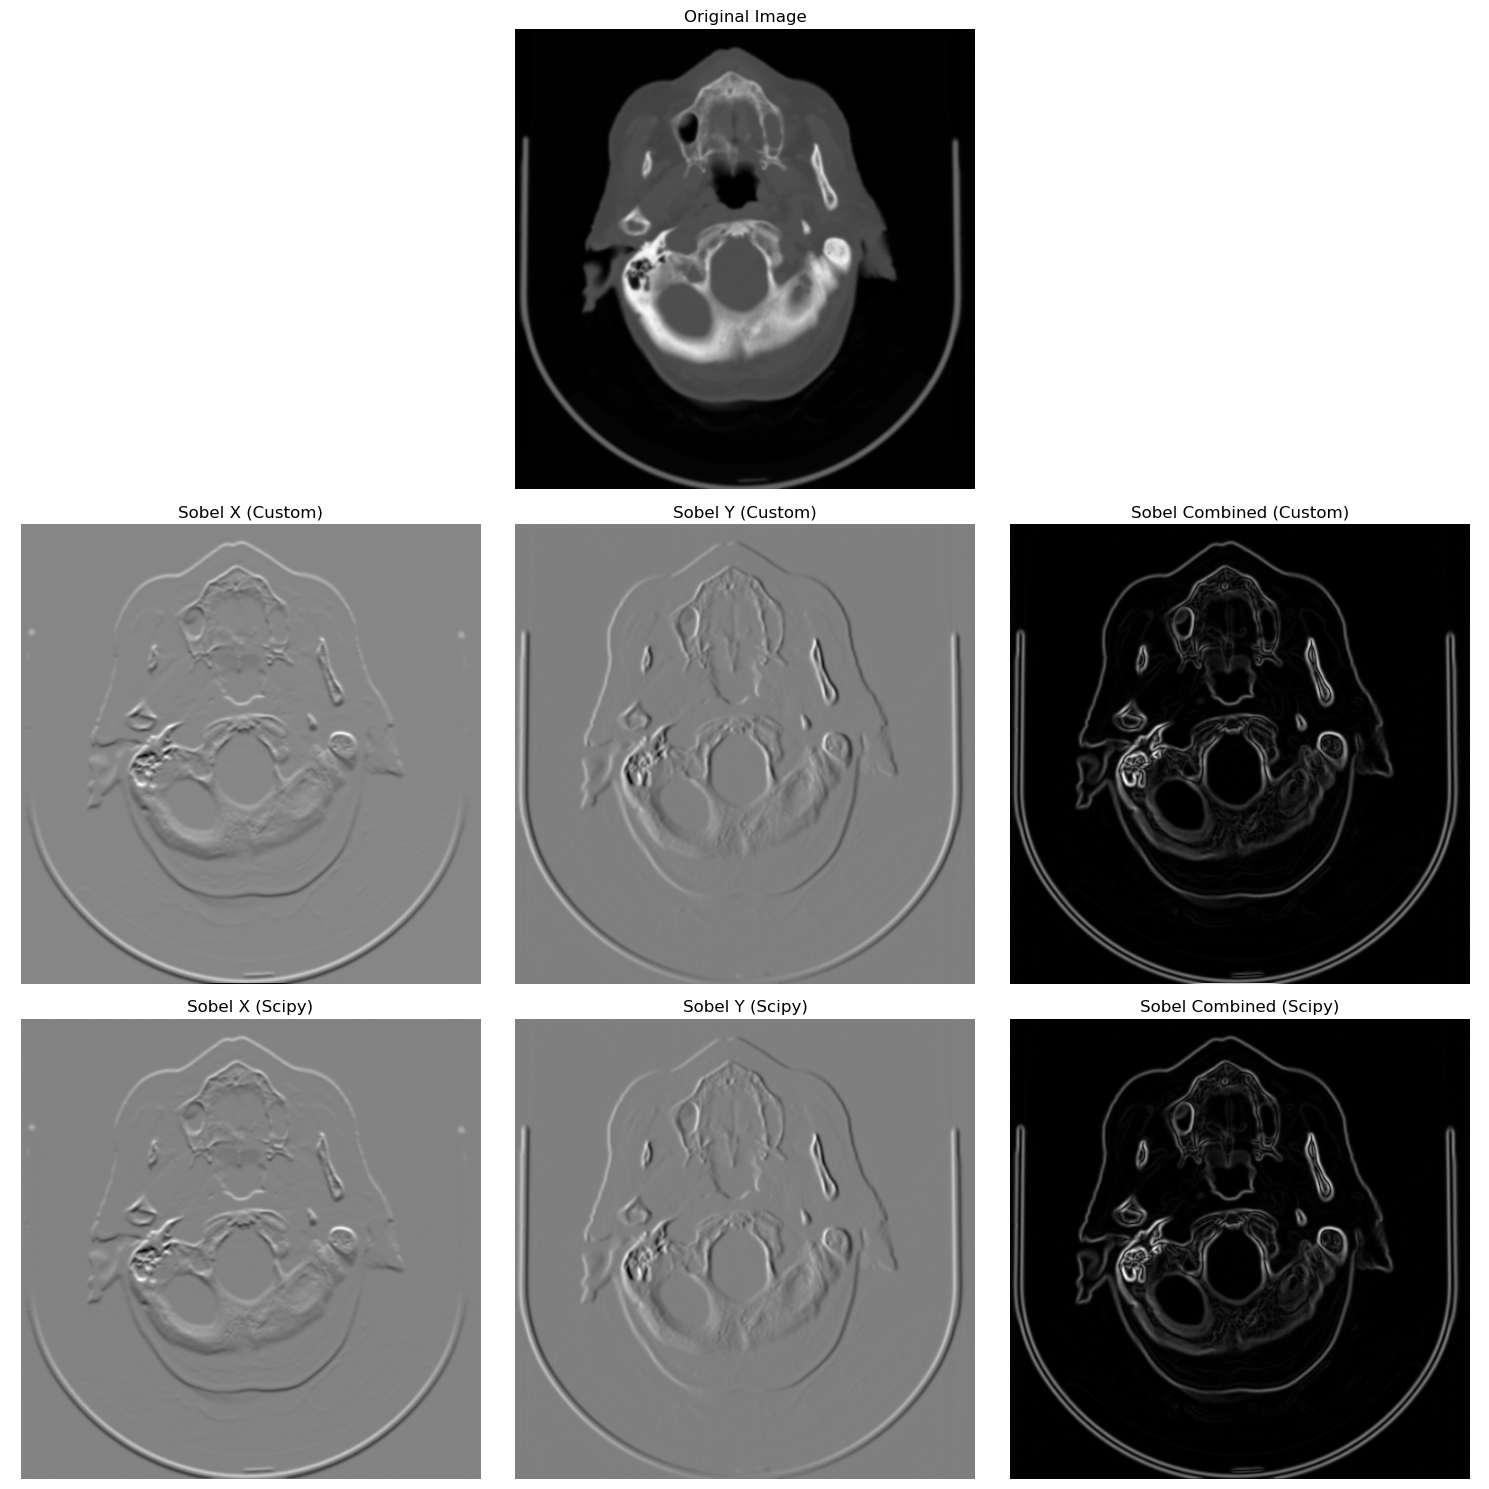

In [73]:
visualize_sobel_3x3(pixel_data_uint8)

In [39]:
from skimage.filters import threshold_otsu

def binarize_image_otsu(image):
    """
    Binarizes an image using Otsu's thresholding.
    """
    threshold = threshold_otsu(image)
    binarized_image = np.where(image > threshold, 255, 0)
    return binarized_image.astype(np.uint8)

In [54]:
def visualize_sobel_binarized(image):
    # Sobel que he implementado
    sobel_x_custom, sobel_y_custom = sobel_custom(3)
    sobel_x_custom = efficient_convolution(pixel_data_uint8, sobel_x_custom)
    sobel_y_custom = efficient_convolution(pixel_data_uint8, sobel_y_custom)
    sobel_combined_custom = normalize_image(np.hypot(sobel_x_custom, sobel_y_custom))

    # Sobel usando scipy.ndimage
    sobel_x_scipy = apply_sobel_scipy(image, axis=0)
    sobel_y_scipy = apply_sobel_scipy(image, axis=1)
    sobel_combined_scipy = normalize_image(apply_sobel_scipy(image))

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    # Original image in the center
    axs[0, 1].imshow(image, cmap='gray')
    axs[0, 1].set_title('Original Image')
    axs[0, 1].axis('off')

    # Visualization of custom Sobel implementation
    axs[1, 0].imshow(binarize_image_otsu(sobel_x_custom), cmap='gray')
    axs[1, 0].set_title('Sobel X + Otsu (Custom)')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(binarize_image_otsu(sobel_y_custom), cmap='gray')
    axs[1, 1].set_title('Sobel Y + Otsu (Custom)')
    axs[1, 1].axis('off')

    axs[1, 2].imshow(binarize_image_otsu(sobel_combined_custom), cmap='gray')
    axs[1, 2].set_title('Sobel Combined + Otsu (Custom)')
    axs[1, 2].axis('off')

    # Visualization of Sobel using scipy.ndimage
    axs[2, 0].imshow(binarize_image_otsu(sobel_x_scipy), cmap='gray')
    axs[2, 0].set_title('Sobel X + Otsu (Scipy)')
    axs[2, 0].axis('off')

    axs[2, 1].imshow(binarize_image_otsu(sobel_y_scipy), cmap='gray')
    axs[2, 1].set_title('Sobel Y + Otsu (Scipy)')
    axs[2, 1].axis('off')

    axs[2, 2].imshow(binarize_image_otsu(sobel_combined_scipy), cmap='gray')
    axs[2, 2].set_title('Sobel Combined + Otsu (Scipy)')
    axs[2, 2].axis('off')

    # Empty positions
    axs[0, 0].axis('off')
    axs[0, 2].axis('off')

    plt.tight_layout()
    plt.show()


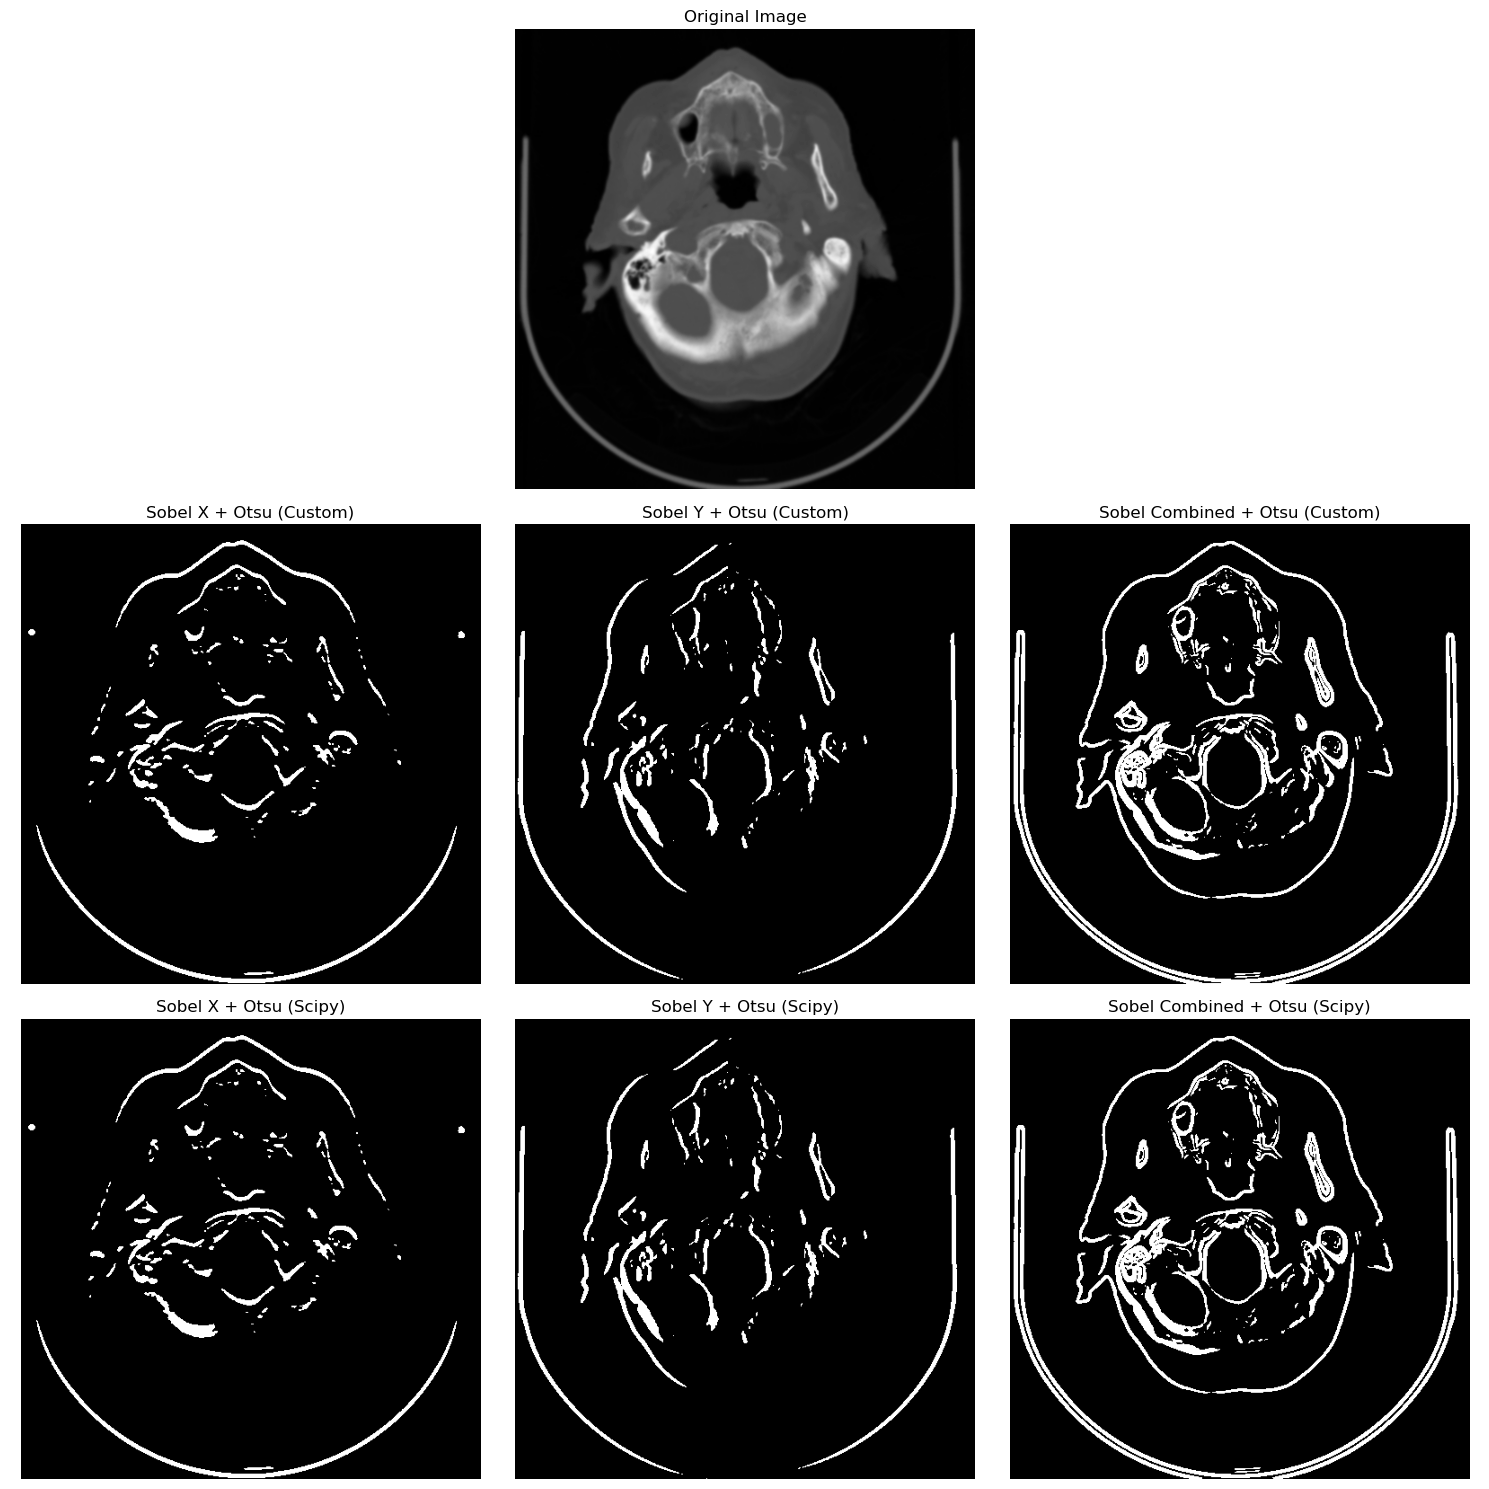

In [55]:
visualize_sobel_binarized(pixel_data_uint8)

## Filtro Gaussiano

In [74]:
def gaussian_filter(kernel_size, sigma):
    # Centrando el kernel en 0, sacamos cuántas unidades tiene simétricamente hacia cada eje
    offset = int(kernel_size // 2)
    # De la malla generada para X, y en el rango -offset:offset+1, se separa en la malla del eje X y del eje y
    x, y = np.mgrid[-offset:offset+1, -offset:offset+1]
    # Teniendo estos valores para rellenar, se aplica la función gaussiana
    gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return gaussian / gaussian.sum()

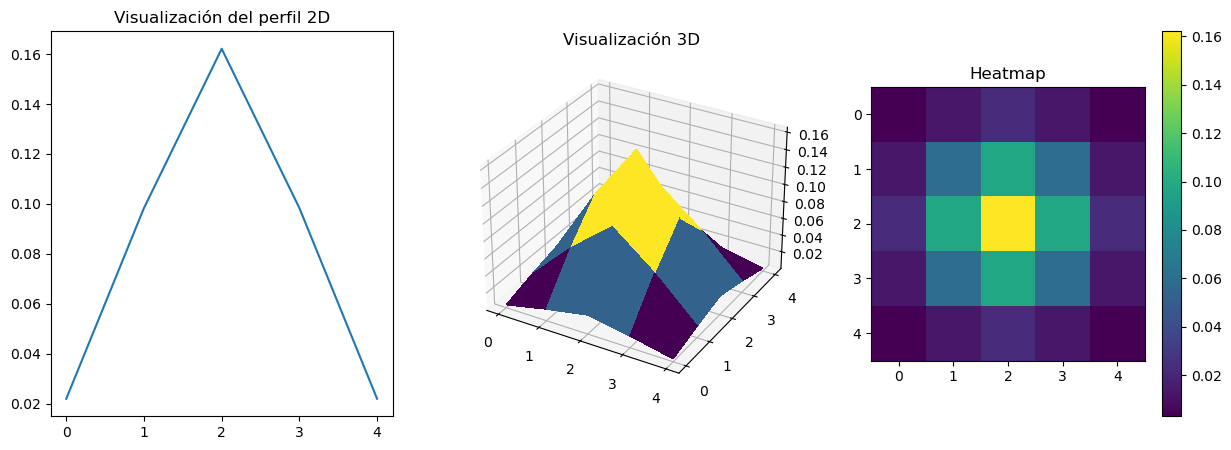

In [75]:
gaussian = gaussian_filter(5, 1)
visualize_filter(gaussian)

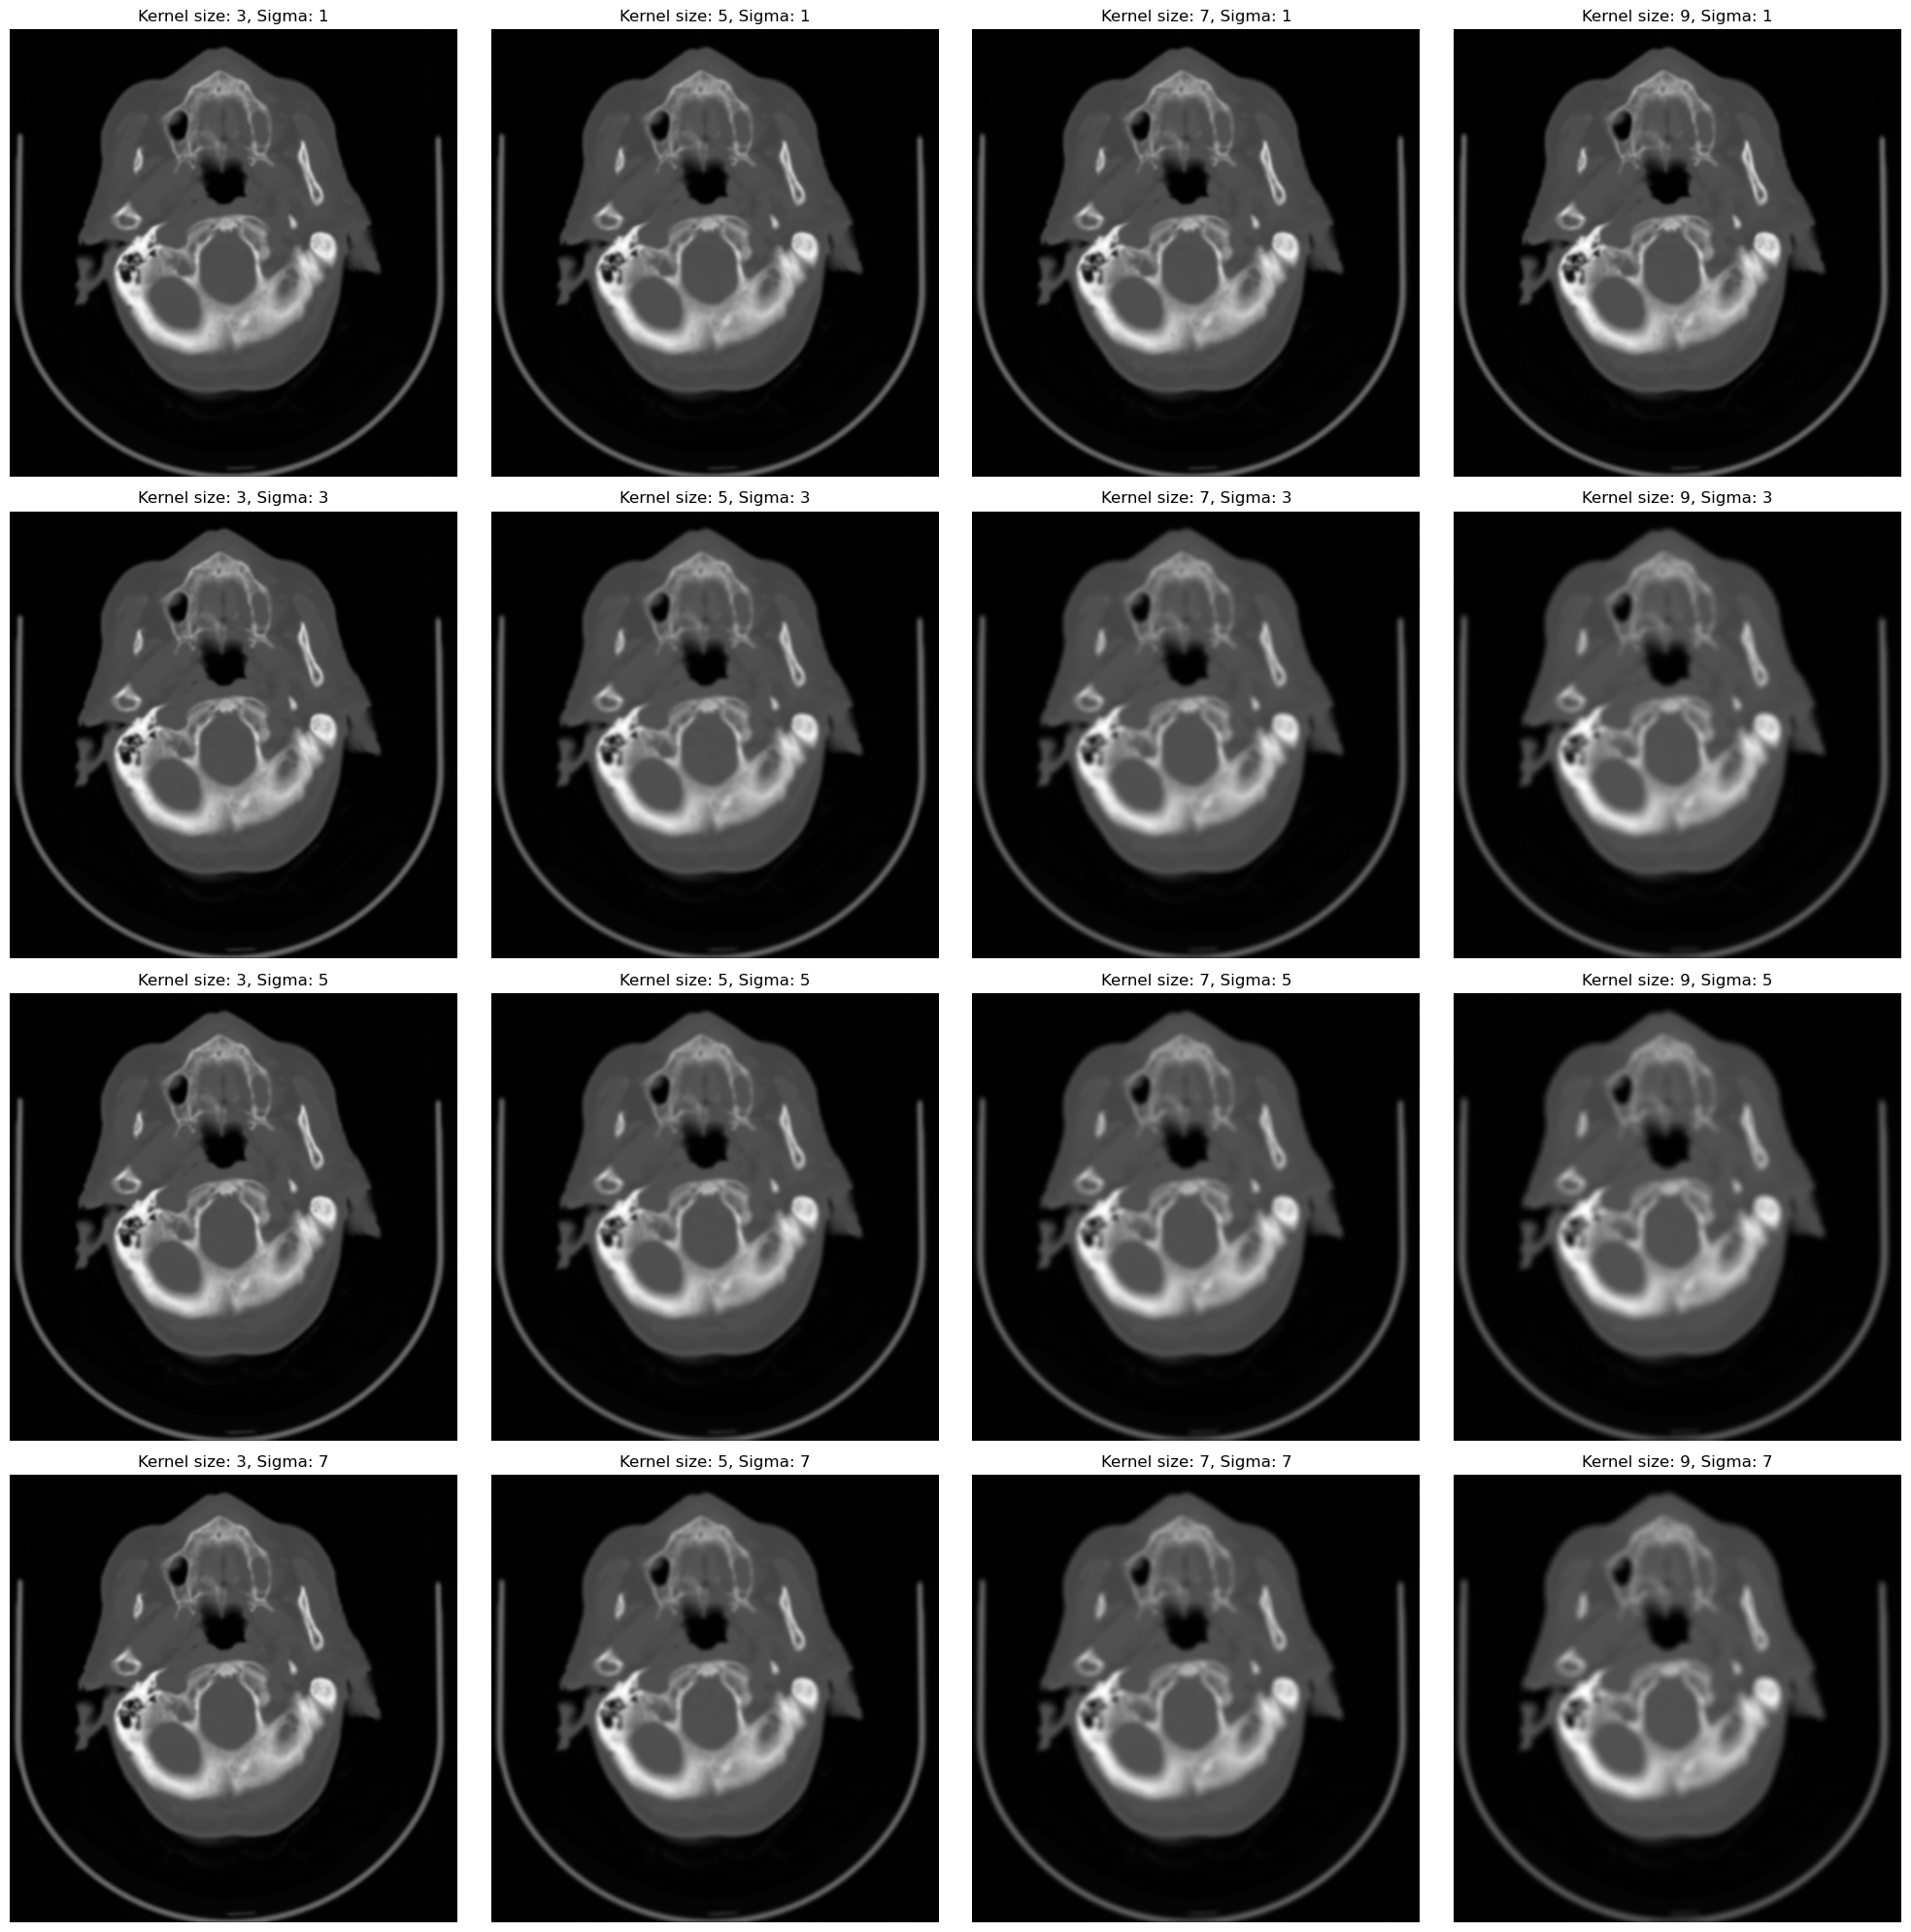

In [77]:
import matplotlib.pyplot as plt

def plt_gaussian(image, kernel_sizes, sigmas):
    """
    Display images after applying Gaussian filter with varying kernel sizes and sigma values.

    Args:
    - image (np.array): Input image.
    - kernel_sizes (list of int): List of kernel sizes.
    - sigmas (list of float): List of sigma values.

    """
    plt.figure(figsize=(20, 20))

    # For each combination of kernel size and sigma
    idx = 1  # Index for subplot
    for sigma in sigmas:
        for size in kernel_sizes:
            plt.subplot(4, 4, idx)
            # Apply the Gaussian filter
            kernel = gaussian_filter(size, sigma)
            plt.imshow(efficient_convolution(image, kernel), cmap='gray')
            plt.title(f"Kernel size: {size}, Sigma: {sigma}")
            plt.axis('off')
            idx += 1

    plt.tight_layout()
    plt.show()

# Use the function with your desired kernel sizes and sigma values
kernel_sizes = [3, 5, 7, 9]
sigmas = [1, 3, 5, 7]
plt_gaussian(pixel_data_uint8, kernel_sizes, sigmas)


## Kernel Laplaciano

In [126]:
from scipy.ndimage import laplace

def apply_laplacian_scipy(img):
    lpl_output = laplace(img)
    return lpl_output

def laplacian_custom(kernel_size):
    center = kernel_size // 2

    # Primer filtro laplaciano
    laplace1 = np.zeros([kernel_size, kernel_size])
    laplace1[center, :] = np.array([1 if i != center else -2 for i in range(kernel_size)])
    laplace1 = laplace1 + laplace1.T
    
    # Segundo filtro laplaciano
    laplace2 = np.ones([kernel_size, kernel_size])
    laplace2[center, center] = -(kernel_size - 1) * (kernel_size - 1)
    
    return laplace1, laplace2

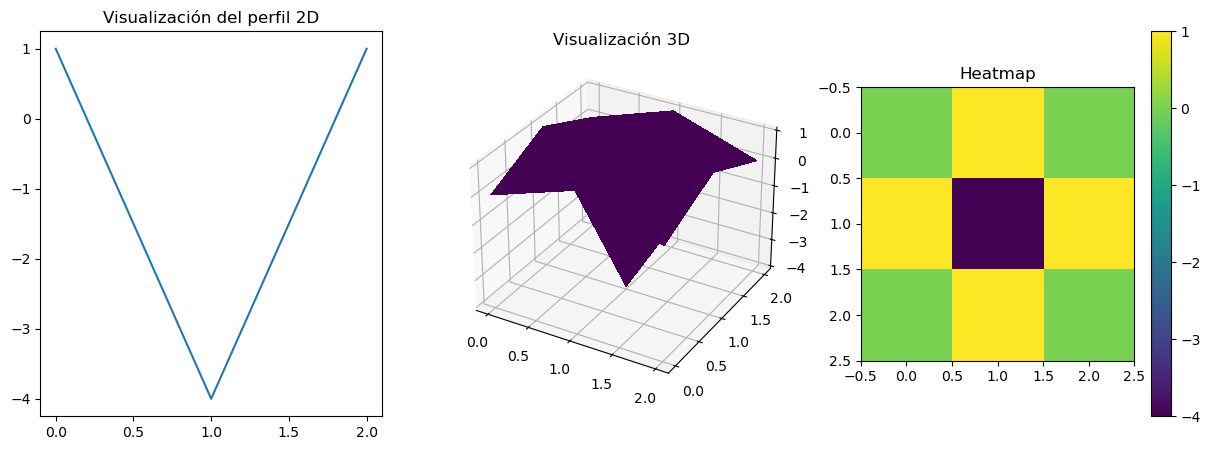

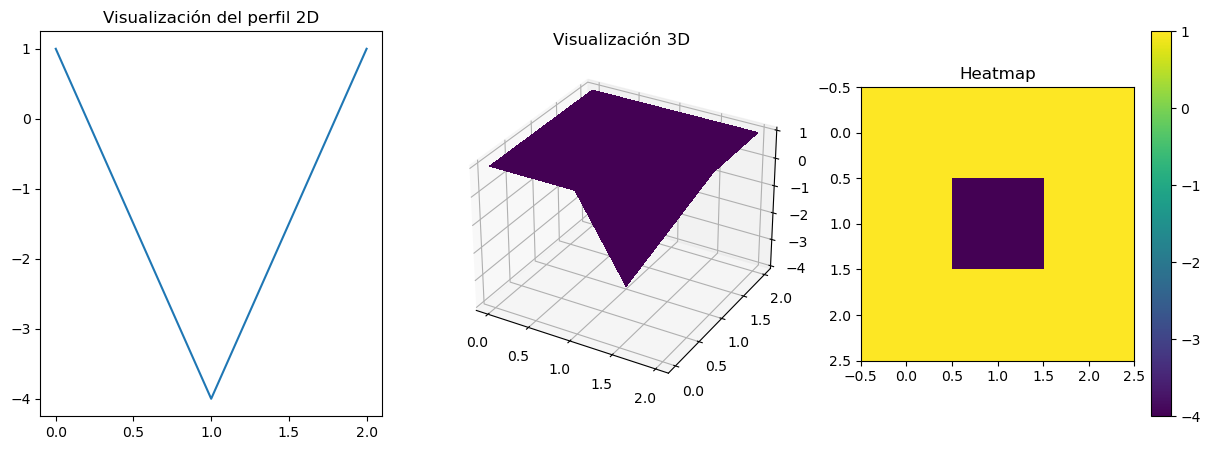

In [104]:
lpl1, lpl2 = laplacian_custom(3)
visualize_filter(lpl1)
visualize_filter(lpl2)

In [128]:
def visualize_laplacian(image):
    lpl1, lpl2 = laplacian_custom(3)
    lpl1 = efficient_convolution(image, lpl1)
    lpl2 = efficient_convolution(image, lpl2)
    lpl_scipy = apply_laplacian_scipy(image)
    
    fig, axes = plt.subplots(2, 3, figsize=(9,9))
    
    axes[0, 1].imshow(image, cmap='gray')
    axes[0, 1].set_title('Original Image')
    axes[0, 1].axis('off')
    axes[0, 0].axis('off')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(lpl1, cmap='gray')
    axes[1, 0].set_title('Image for Laplacian Kernel 1')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(lpl2, cmap='gray')
    axes[1, 1].set_title('Image for Laplacian Kernel 2')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(normalize_image(lpl_scipy), cmap='gray')
    axes[1, 2].set_title('Image for Laplacian Kernel (Scipy)')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

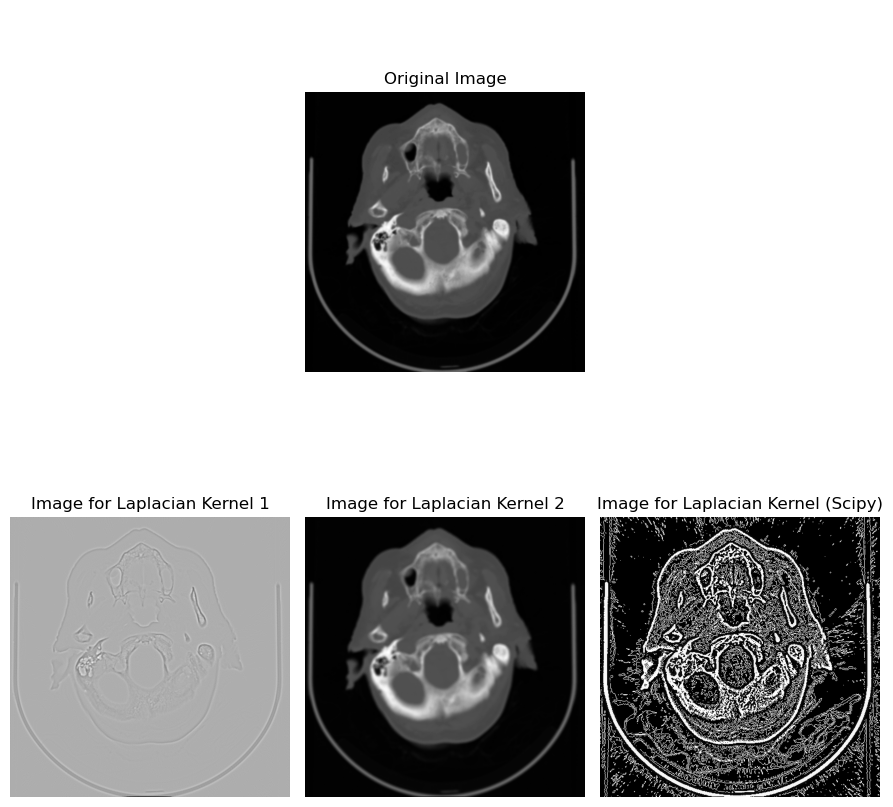

In [130]:
visualize_laplacian(pixel_data_uint8)